# Exploratory Data Analysis (EDA)
**Project:** Hybrid Receipt Parsing System (YOLO + OCR)

**Dataset:** SROIE 2019 (Scanned Receipt OCR and Information Extraction)

## Objectives
1. Understand the **variance and characteristics** of receipt images
2. Analyze image dimensions, aspect ratios, and quality metrics
3. Quantify pixel intensity distributions (brightness & contrast)
4. Identify preprocessing requirements based on data patterns
5. Determine empirical thresholds for adaptive preprocessing

## Dataset Overview
- **Train Set:** 626 receipt images
- **Test Set:** 347 receipt images
- **Fields:** Company/Vendor, Date, Address, Total
- **Annotations:** Bounding boxes (8-point polygons) + text labels

## Setup & Imports

In [5]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import pandas as pd
from PIL import Image

In [3]:
import os
from pathlib import Path

# Determine if running in Google Colab and set paths accordingly
if 'COLAB_GPU' in os.environ:
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_PATH = Path('/content/drive/MyDrive/data')
else:
    DATA_PATH = Path('../data')
    print("Not running in Google Colab. Skipping Google Drive mounting.")

# Define the RAW_DIR once after setting DATA_PATH
RAW_DIR = DATA_PATH / "raw/SROIE2019"

Not running in Google Colab. Skipping Google Drive mounting.


In [6]:
%matplotlib inline
sns.set_style('whitegrid')

# Verify paths
print(f"Data path exists: {DATA_PATH.exists()}")
print(f"Raw data path: {RAW_DIR}")
print(f"Train images: {(RAW_DIR / 'train/img').exists()}")
print(f"Test images: {(RAW_DIR / 'test/img').exists()}")

Data path exists: True
Raw data path: ../data/raw/SROIE2019
Train images: True
Test images: True


## 1. Dataset Statistics

In [7]:
def count_files(directory, extensions=('.jpg', '.jpeg', '.png')):
    """Count files with specific extensions in a directory"""
    if not directory.exists():
        return 0
    return sum(1 for f in directory.iterdir()
               if f.is_file() and f.suffix.lower() in extensions)

# Count images
train_count = count_files(RAW_DIR / "train/img")
test_count = count_files(RAW_DIR / "test/img")

print("="*50)
print("DATASET STATISTICS")
print("="*50)
print(f"Train images: {train_count}")
print(f"Test images:  {test_count}")
print(f"Total images: {train_count + test_count}")
print(f"Train/Test split: {train_count/(train_count+test_count)*100:.1f}% / {test_count/(train_count+test_count)*100:.1f}%")

DATASET STATISTICS
Train images: 626
Test images:  347
Total images: 973
Train/Test split: 64.3% / 35.7%


## 2. Image Quality Analysis

Analyze key metrics to understand preprocessing requirements:
- **Mean Pixel Intensity:** Brightness (0=black, 255=white)
- **Standard Deviation:** Contrast indicator
- **Image Dimensions:** Width, height, aspect ratio

In [8]:
def analyze_image_quality(img_dir, max_images=500):
    """
    Analyze image quality metrics from a directory.

    Returns:
        DataFrame with columns: filename, width, height, mean, std, aspect_ratio
    """
    results = []
    files = list(img_dir.glob("*.jpg"))[:max_images]

    for img_path in tqdm(files, desc="Analyzing images"):
        try:
            # Load image
            img = cv2.imread(str(img_path))
            if img is None:
                continue

            # Get dimensions
            h, w = img.shape[:2]

            # Convert to grayscale for analysis
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Calculate statistics
            mean_intensity = np.mean(gray)
            std_intensity = np.std(gray)
            aspect_ratio = h / w

            results.append({
                'filename': img_path.name,
                'width': w,
                'height': h,
                'mean': mean_intensity,
                'std': std_intensity,
                'aspect_ratio': aspect_ratio
            })

        except Exception as e:
            print(f"Error processing {img_path.name}: {e}")

    return pd.DataFrame(results)

# Analyze train set
print("Analyzing training set...")
train_stats = analyze_image_quality(RAW_DIR / "train/img")

print("\nAnalyzing test set...")
test_stats = analyze_image_quality(RAW_DIR / "test/img")

print(f"\nTrain set analyzed: {len(train_stats)} images")
print(f"Test set analyzed: {len(test_stats)} images")

Analyzing training set...


Analyzing images:   0%|          | 0/500 [00:00<?, ?it/s]

Corrupt JPEG data: bad Huffman code



Analyzing test set...


Analyzing images:   0%|          | 0/347 [00:00<?, ?it/s]


Train set analyzed: 500 images
Test set analyzed: 347 images


### 2.1 Summary Statistics

In [9]:
print("="*70)
print("TRAIN SET STATISTICS")
print("="*70)
print(train_stats[['width', 'height', 'mean', 'std', 'aspect_ratio']].describe())

print("\n" + "="*70)
print("TEST SET STATISTICS")
print("="*70)
print(test_stats[['width', 'height', 'mean', 'std', 'aspect_ratio']].describe())

TRAIN SET STATISTICS
             width       height        mean         std  aspect_ratio
count   500.000000   500.000000  500.000000  500.000000    500.000000
mean   1324.836000  2361.580000  235.270795   39.762096      2.062343
std    1417.353528  1845.089495   17.080263   13.027221      0.490949
min     436.000000   605.000000  144.350001   10.255632      1.029491
25%     623.000000  1386.000000  232.240754   29.333070      1.726280
50%     800.500000  1690.500000  239.315022   39.263050      1.993951
75%     934.000000  2132.000000  244.888181   48.408210      2.368762
max    4961.000000  7016.000000  253.718854   84.956260      3.795091

TEST SET STATISTICS
             width       height        mean         std  aspect_ratio
count   347.000000   347.000000  347.000000  347.000000    347.000000
mean   1420.541787  2483.097983  235.888982   39.958771      2.029689
std    1498.547999  1948.202747   17.403262   13.658578      0.486942
min     435.000000   776.000000  146.919478   17

## 3. Image Dimensions Distribution

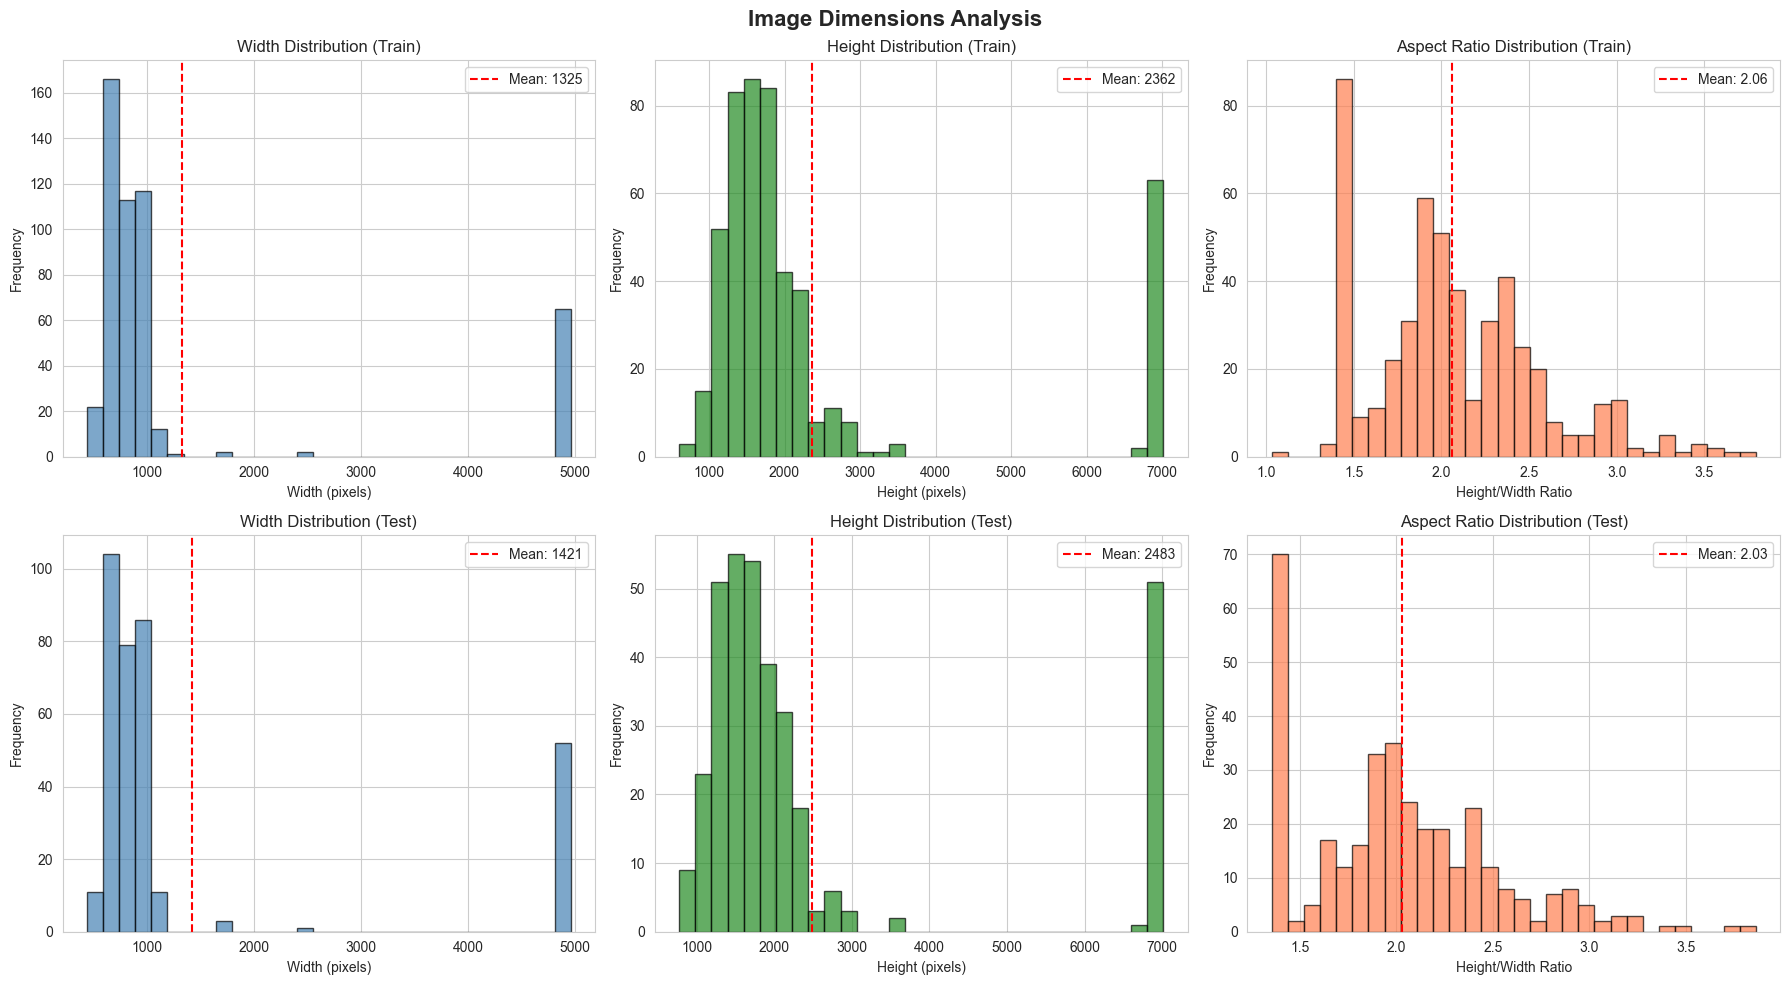

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Image Dimensions Analysis', fontsize=16, fontweight='bold')

# Width distribution
axes[0, 0].hist(train_stats['width'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Width Distribution (Train)')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(train_stats['width'].mean(), color='red', linestyle='--', label=f"Mean: {train_stats['width'].mean():.0f}")
axes[0, 0].legend()

# Height distribution
axes[0, 1].hist(train_stats['height'], bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Height Distribution (Train)')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_stats['height'].mean(), color='red', linestyle='--', label=f"Mean: {train_stats['height'].mean():.0f}")
axes[0, 1].legend()

# Aspect ratio distribution
axes[0, 2].hist(train_stats['aspect_ratio'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[0, 2].set_title('Aspect Ratio Distribution (Train)')
axes[0, 2].set_xlabel('Height/Width Ratio')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].axvline(train_stats['aspect_ratio'].mean(), color='red', linestyle='--',
                   label=f"Mean: {train_stats['aspect_ratio'].mean():.2f}")
axes[0, 2].legend()

# Test set visualizations
axes[1, 0].hist(test_stats['width'], bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[1, 0].set_title('Width Distribution (Test)')
axes[1, 0].set_xlabel('Width (pixels)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(test_stats['width'].mean(), color='red', linestyle='--', label=f"Mean: {test_stats['width'].mean():.0f}")
axes[1, 0].legend()

axes[1, 1].hist(test_stats['height'], bins=30, color='forestgreen', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('Height Distribution (Test)')
axes[1, 1].set_xlabel('Height (pixels)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(test_stats['height'].mean(), color='red', linestyle='--', label=f"Mean: {test_stats['height'].mean():.0f}")
axes[1, 1].legend()

axes[1, 2].hist(test_stats['aspect_ratio'], bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1, 2].set_title('Aspect Ratio Distribution (Test)')
axes[1, 2].set_xlabel('Height/Width Ratio')
axes[1, 2].set_ylabel('Frequency')
axes[1, 2].axvline(test_stats['aspect_ratio'].mean(), color='red', linestyle='--',
                   label=f"Mean: {test_stats['aspect_ratio'].mean():.2f}")
axes[1, 2].legend()

plt.tight_layout()
plt.show()

## 4. Image Quality Distribution (Brightness & Contrast)

This is **critical** for determining preprocessing strategy:
- **Low STD (<30):** Faint/low-contrast images → Need CLAHE enhancement
- **Medium STD (30-55):** Normal images → Standard preprocessing
- **High STD (>55):** Shadowed/high-contrast → Need adaptive thresholding

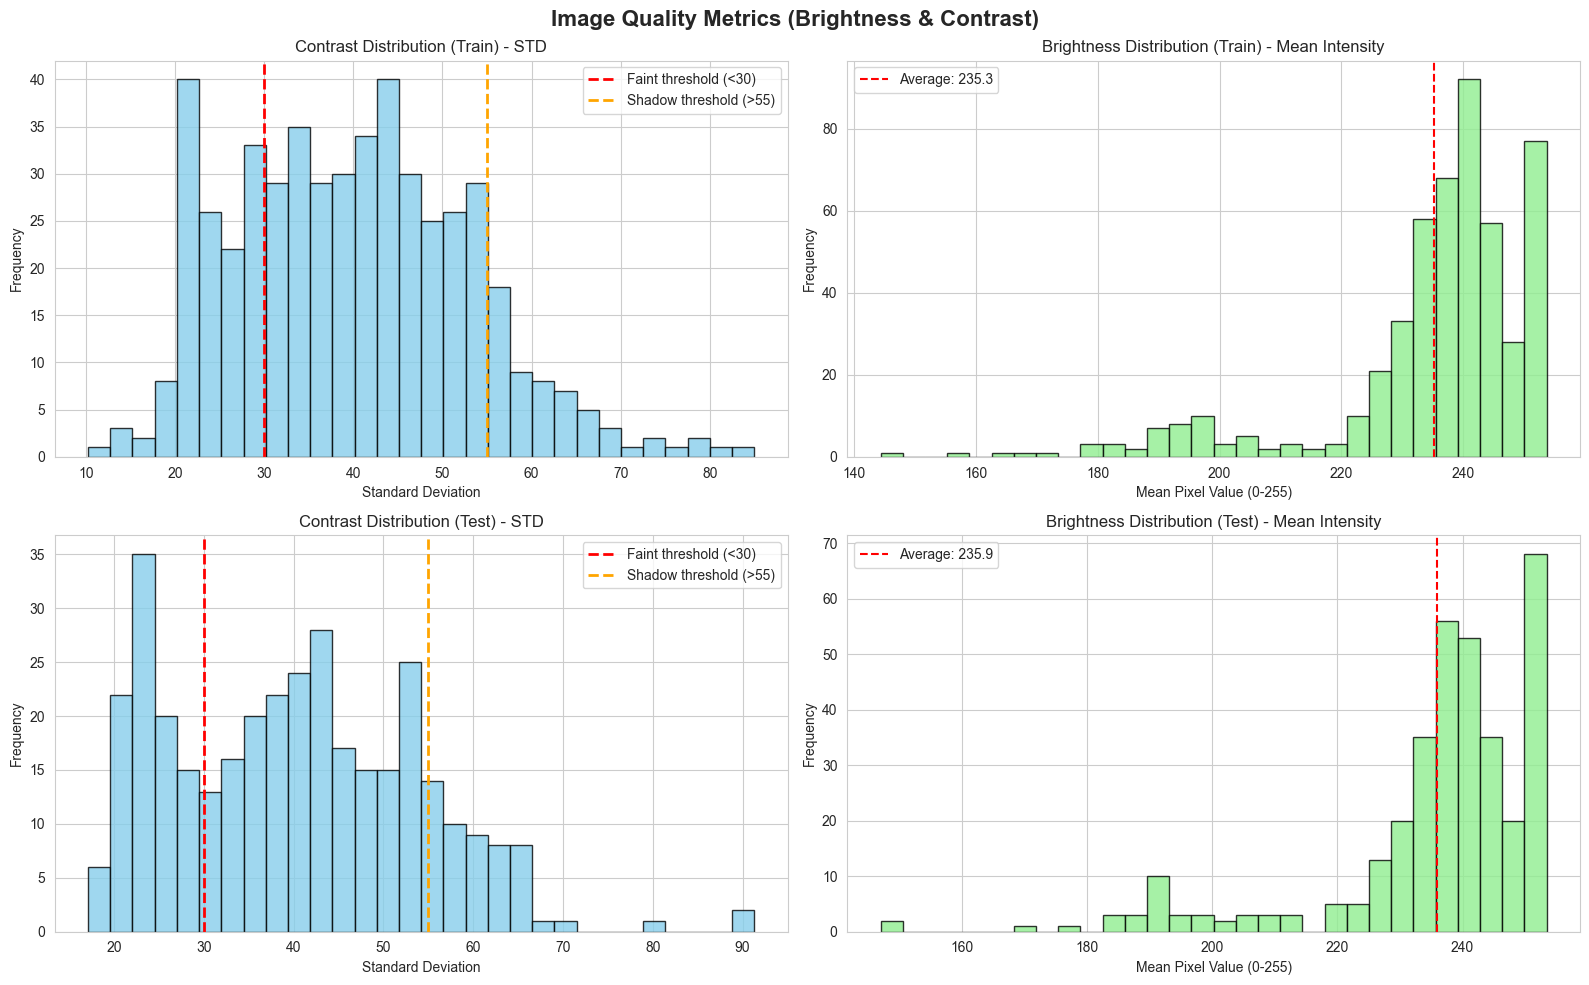

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Image Quality Metrics (Brightness & Contrast)', fontsize=16, fontweight='bold')

# Contrast (STD) - Train
axes[0, 0].hist(train_stats['std'], bins=30, color='skyblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_title('Contrast Distribution (Train) - STD', fontsize=12)
axes[0, 0].set_xlabel('Standard Deviation')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(30, color='red', linestyle='--', linewidth=2, label='Faint threshold (<30)')
axes[0, 0].axvline(55, color='orange', linestyle='--', linewidth=2, label='Shadow threshold (>55)')
axes[0, 0].legend()

# Brightness (Mean) - Train
axes[0, 1].hist(train_stats['mean'], bins=30, color='lightgreen', alpha=0.8, edgecolor='black')
axes[0, 1].set_title('Brightness Distribution (Train) - Mean Intensity', fontsize=12)
axes[0, 1].set_xlabel('Mean Pixel Value (0-255)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].axvline(train_stats['mean'].mean(), color='red', linestyle='--',
                   label=f"Average: {train_stats['mean'].mean():.1f}")
axes[0, 1].legend()

# Contrast (STD) - Test
axes[1, 0].hist(test_stats['std'], bins=30, color='skyblue', alpha=0.8, edgecolor='black')
axes[1, 0].set_title('Contrast Distribution (Test) - STD', fontsize=12)
axes[1, 0].set_xlabel('Standard Deviation')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].axvline(30, color='red', linestyle='--', linewidth=2, label='Faint threshold (<30)')
axes[1, 0].axvline(55, color='orange', linestyle='--', linewidth=2, label='Shadow threshold (>55)')
axes[1, 0].legend()

# Brightness (Mean) - Test
axes[1, 1].hist(test_stats['mean'], bins=30, color='lightgreen', alpha=0.8, edgecolor='black')
axes[1, 1].set_title('Brightness Distribution (Test) - Mean Intensity', fontsize=12)
axes[1, 1].set_xlabel('Mean Pixel Value (0-255)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].axvline(test_stats['mean'].mean(), color='red', linestyle='--',
                   label=f"Average: {test_stats['mean'].mean():.1f}")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 4.1 Quality Category Distribution

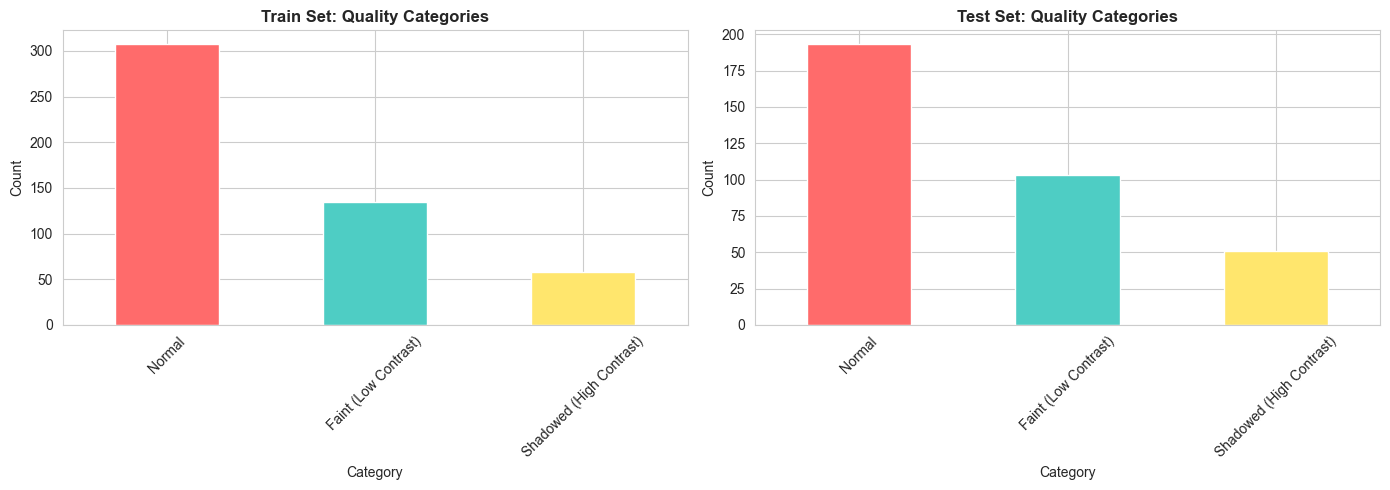


QUALITY CATEGORY DISTRIBUTION

Train Set:
quality_category
Normal                      307
Faint (Low Contrast)        135
Shadowed (High Contrast)     58
Name: count, dtype: int64

Percentages:
quality_category
Normal                      61.4
Faint (Low Contrast)        27.0
Shadowed (High Contrast)    11.6
Name: count, dtype: float64


Test Set:
quality_category
Normal                      193
Faint (Low Contrast)        103
Shadowed (High Contrast)     51
Name: count, dtype: int64

Percentages:
quality_category
Normal                      55.6
Faint (Low Contrast)        29.7
Shadowed (High Contrast)    14.7
Name: count, dtype: float64


In [12]:
def categorize_quality(std):
    """Categorize image based on contrast (std)"""
    if std < 30:
        return 'Faint (Low Contrast)'
    elif std <= 55:
        return 'Normal'
    else:
        return 'Shadowed (High Contrast)'

train_stats['quality_category'] = train_stats['std'].apply(categorize_quality)
test_stats['quality_category'] = test_stats['std'].apply(categorize_quality)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

train_stats['quality_category'].value_counts().plot(kind='bar', ax=axes[0], color=['#ff6b6b', '#4ecdc4', '#ffe66d'])
axes[0].set_title('Train Set: Quality Categories', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

test_stats['quality_category'].value_counts().plot(kind='bar', ax=axes[1], color=['#ff6b6b', '#4ecdc4', '#ffe66d'])
axes[1].set_title('Test Set: Quality Categories', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Category')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print percentages
print("\n" + "="*50)
print("QUALITY CATEGORY DISTRIBUTION")
print("="*50)
print("\nTrain Set:")
print(train_stats['quality_category'].value_counts())
print(f"\nPercentages:")
print((train_stats['quality_category'].value_counts() / len(train_stats) * 100).round(1))

print("\n\nTest Set:")
print(test_stats['quality_category'].value_counts())
print(f"\nPercentages:")
print((test_stats['quality_category'].value_counts() / len(test_stats) * 100).round(1))

## 5. Visual Comparison: Sample Images by Quality

Sample images from each quality category:



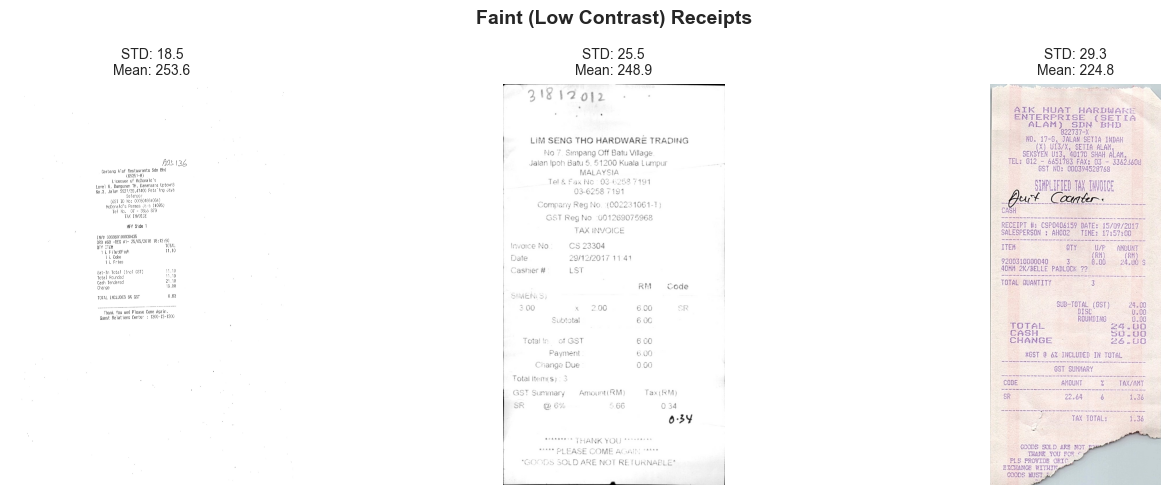

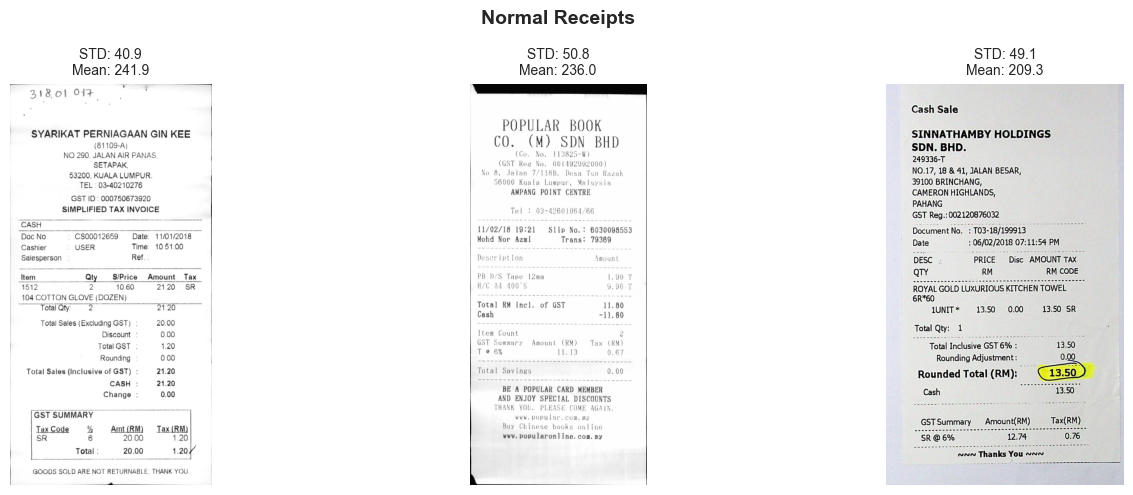

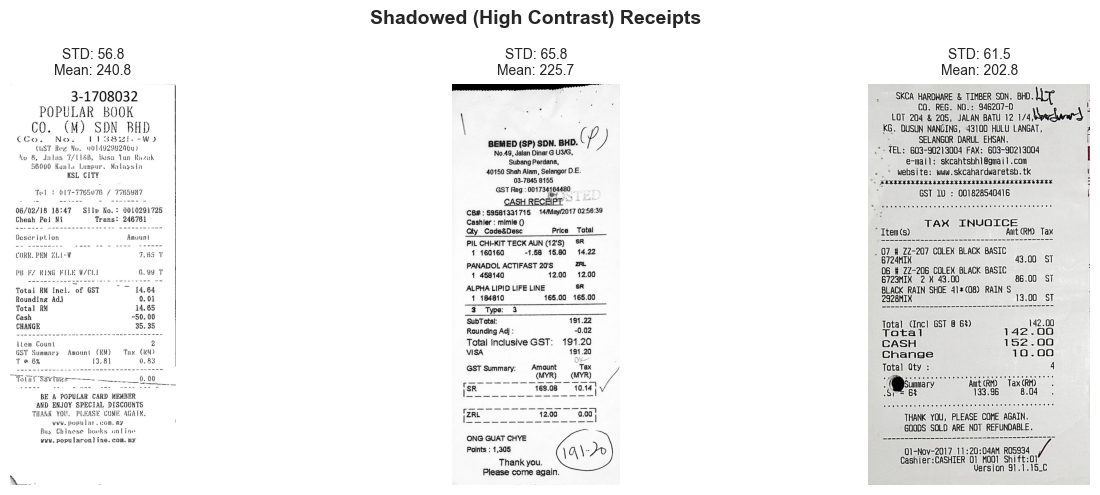

In [13]:
def show_samples_by_category(df, img_dir, n_samples=3):
    """
    Display sample images from each quality category
    """
    categories = df['quality_category'].unique()

    for category in categories:
        category_samples = df[df['quality_category'] == category].sample(min(n_samples, len(df[df['quality_category'] == category])))

        fig, axes = plt.subplots(1, len(category_samples), figsize=(15, 5))
        if len(category_samples) == 1:
            axes = [axes]

        fig.suptitle(f'{category} Receipts', fontsize=14, fontweight='bold')

        for idx, (_, row) in enumerate(category_samples.iterrows()):
            img_path = img_dir / row['filename']
            img = cv2.imread(str(img_path))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            axes[idx].imshow(img_rgb)
            axes[idx].set_title(f"STD: {row['std']:.1f}\nMean: {row['mean']:.1f}", fontsize=10)
            axes[idx].axis('off')

        plt.tight_layout()
        plt.show()

print("Sample images from each quality category:\n")
show_samples_by_category(train_stats, RAW_DIR / "train/img", n_samples=3)

## 6. Key Findings & Preprocessing Recommendations

### Image Characteristics:
1. **Dimensions:** Highly variable (requires resizing for model training)
2. **Aspect Ratios:** Receipts are typically tall (height > width)
3. **Quality Variance:** Significant differences in brightness and contrast

### Quality Categories Identified:

#### 🔴 Faint Images (STD < 30)
- **Problem:** Very low contrast, fading ink, poor scan quality
- **Solution:** CLAHE (Contrast Limited Adaptive Histogram Equalization)
- **Parameters:** clipLimit=1.8-2.5, tileGridSize=(8,8)

#### 🟢 Normal Images (STD 30-55)
- **Problem:** Minor noise, slight blur
- **Solution:** Standard preprocessing (Gaussian blur + moderate CLAHE)
- **Parameters:** GaussianBlur(3,3), clipLimit=2.0-2.5

#### 🟠 Shadowed Images (STD > 55)
- **Problem:** Strong shadows, uneven illumination, high contrast backgrounds
- **Solution:** Adaptive thresholding to remove background
- **Parameters:** adaptiveThreshold with GAUSSIAN_C method

### Preprocessing Strategy:
```python
if std < 30:
    apply_light_preprocessing()  # CLAHE focused
elif 30 <= std <= 55:
    apply_medium_preprocessing()  # Balanced approach
else:
    apply_heavy_preprocessing()  # Adaptive threshold
```

This adaptive approach ensures:
- ✅ Faint receipts are enhanced without over-processing
- ✅ Normal receipts maintain quality
- ✅ Shadowed receipts have background removed
- ✅ Better OCR accuracy downstream

## 7. Export Analysis Results

In [ ]:
# Save statistics to CSV
output_dir = DATA_PATH / "analysis"
output_dir.mkdir(exist_ok=True)

train_stats.to_csv(output_dir / "train_image_stats.csv", index=False)
test_stats.to_csv(output_dir / "test_image_stats.csv", index=False)

print(f"✅ Analysis results saved to {output_dir}")
print(f"   - train_image_stats.csv ({len(train_stats)} records)")
print(f"   - test_image_stats.csv ({len(test_stats)} records)")

## Next Steps

**Preprocessing:** Implement adaptive preprocessing based on these thresholds
- Notebook: `01_Preprocess.ipynb`
- Apply quality-based preprocessing strategies
- Generate processed images for both OCR and YOLO training